# Notebook to analyze the data from AGNs catalogs

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.  
We will analyze the fluxes for the sources.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.io import fits
# from astropy.table import Table
# from astropy.table import Column
# from astropy.table import MaskedColumn
# from astropy.table import hstack
# from astropy.table import vstack
# from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import getpass
import progressbar
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [6]:
def combine_errors(errors_array):
    # errors_array[~(errors_array > 0)] = 0.0
    squared_vals                      = np.square(errors_array)
    square_root                       = np.sqrt(np.nansum(squared_vals, axis=1))
    return square_root

In [7]:
def get_error_comb(columns_err, columns_upl, flux_err_df, up_lim_flag_df):
    temp_flux_err   = flux_err_df[columns_err].to_numpy(copy=True)
    temp_flux_uplim = flux_err_df[columns_err].to_numpy(copy=True)
    temp_upl_flag   = up_lim_flag_df[columns_upl].to_numpy(copy=True)
    temp_flux_err[temp_upl_flag]            = 0.0
    error_array     = combine_errors(temp_flux_err)
    up_lims_flag    = np.array([False] * np.shape(error_array)[0])
    temp_flux_uplim[~temp_upl_flag]         = np.nan
    up_lim_array    = np.nanmin(temp_flux_uplim, axis=1)
    error_filt      = np.array(error_array  > 0.0) & np.array(error_array  < np.inf)
    up_lim_filt     = np.array(up_lim_array > 0.0) & np.array(up_lim_array < np.inf)
    error_array[~error_filt  & up_lim_filt] = up_lim_array[~error_filt & up_lim_filt]
    up_lims_flag[~error_filt & up_lim_filt] = True
    return error_array, up_lims_flag

In [8]:
def get_up_lim_comb(columns_err, columns_upl, flux_err_df, up_lim_flag_df):
    temp_flux_err = flux_err_df[columns_err].to_numpy()
    temp_upl_flag = up_lim_flag_df[columns_upl].to_numpy()
    temp_flux_err[~temp_flag] = np.inf
    up_lim_array  = np.nanmin(temp_flux_err, axis=1)
    return up_lim_array

In [9]:
def combine_simbad_ned_errs(band_name):
    band_a = band_name
    if band_name == 'r':
        band_b = 'R'
    else:
        band_b = band_name
    temp_data_flx = pd.DataFrame({('Flux ' + band_a):merged_flux_catalog_df[('Flux ' + band_a)],\
                                  ('FLUX_' + band_b):flux_catalog_df[('FLUX_' + band_b)]})
    temp_data_err = pd.DataFrame({('Flux Error ' + band_a):merged_flux_unc_catalog_df[('Flux Error ' + band_a)],\
                                  ('FLUX_ERROR_' + band_b):flux_uncerts_catalog_df[('FLUX_ERROR_' + band_b)]})
    temp_data_upl = pd.DataFrame({('Upper Limit ' + band_a):merged_up_lim_catalog_df[('Upper Limit ' + band_a)],\
                                  ('FLUX_' + band_b):~np.array(flux_catalog_df[('FLUX_' + band_b)] > 0.0)})
    
    temp_flux_err_det = temp_data_err.to_numpy(copy=True)
    temp_flux_err_upl = temp_data_err.to_numpy(copy=True)
    temp_flux_uplim   = temp_data_upl.to_numpy(copy=True)
    
    temp_flux_err_det[temp_flux_uplim]  = np.nan
    temp_flux_err_upl[~temp_flux_uplim] = np.nan
    
    comb_err_det      = np.sqrt(np.nansum(np.square(temp_flux_err_det), axis=1))
    comb_err_upl      = np.nanmin(temp_flux_err_upl, axis=1)
    
    array_flx         = temp_data_flx.median(axis='columns', skipna=True)
    merged_flux_unc_catalog_df.loc[np.array(comb_err_det > 0), ('Flux Error ' + band_a)] = comb_err_det[np.array(comb_err_det > 0)]
    merged_flux_unc_catalog_df.loc[np.array(comb_err_upl > 0), ('Flux Error ' + band_a)] = comb_err_upl[np.array(comb_err_upl > 0)]
    
    return array_flx


Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [10]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)
        # mcolors.LogNorm.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

---

## Reading data

In [11]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

It is important to keep in mind that columns with keys starting with `Flux Density...` are in `Jy`.  
All the other values, are expressed in `mJy`.

Columns with uncertainties (`NED Uncertainty...`) have been saved as strings, to preserve possible upper limits.

In [12]:
# large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')
# large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned_all_cols.h5', 'df')
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned_ago2020.h5', 'df')

In [13]:
np.shape(large_catalog_df)

(19840, 2532)

Data could be also converted into `astropy` Tables.

In [14]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [15]:
# np.savetxt(cat_path + 'column_names_flx.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')
# np.savetxt(cat_path + 'column_names_flx_2_5_arcsec.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

From the querying process, some columns have the same identifier.  
In those cases, the suffix `_x` or `_y` has been added (`_x` for `simbad` data, and `_y` for `Ned` photometry).
One example is shown below.

---

## Organize data

Separate data into different arrays for calculations

Repeated keywords are: `MAIN_ID_x`, `MAIN_ID_y`, `COORD_x`, and `COORD_y`

The following redshift column comes from `SDSS` with the highest quality flag selected.

In [16]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
F_20cm      = large_catalog_df['F_20CM']
F_20cm_e    = large_catalog_df['F_20CM_ERR']
F_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']
origin_flag = large_catalog_df['ORIGIN'].astype(int)         # 0:SDSS+FIRST, 1:COSMOS, 2:Stripe82, 3:Inayoshi
refs_vals   = large_catalog_df['REFS']
flx_lims    = large_catalog_df['FLX_LIM']  # 1.4 GHz flux limit (mJy) for the observations they come from

In [17]:
ra_deg      = large_catalog_df['RA_d']
dec_deg     = large_catalog_df['DEC_d']
init_names  = large_catalog_df['MAIN_ID_x']  # Initial name (from catalog or Simbad)
newer_names = large_catalog_df['MAIN_ID_y']  # Secondary name (mainly from Ned)

Fix redshift uncertainties.

In [18]:
filter_z_err_ned = np.array(large_catalog_df['ned_z_err'] == -999)
large_catalog_df.loc[filter_z_err_ned, 'ned_z_err'] = np.nan

In [19]:
np.sum(np.isfinite(large_catalog_df['Z_OWN_ERR']))

49

In [20]:
filter_err_z_own = ~np.isfinite(large_catalog_df['Z_OWN_ERR'])
filter_err_z_ned = np.isfinite(large_catalog_df['ned_z_err'])

In [21]:
large_catalog_df.loc[filter_err_z_ned, 'Z_OWN_ERR'] = large_catalog_df.loc[filter_err_z_ned, 'ned_z_err']

In [22]:
filter_z_err_own = np.array(large_catalog_df['Z_OWN_ERR'] < 0)
large_catalog_df.loc[filter_z_err_own, 'Z_OWN_ERR'] = 0.0

In [23]:
redshift_e  = large_catalog_df['Z_OWN_ERR']

In [24]:
np.sum(np.isfinite(large_catalog_df['Z_OWN_ERR']))

7549

We can calculate luminosities from fluxes.

In this case, we first select the columns with fluxes in a numerical format  
(with this all error columns are discarded for the moment).  

But first, we convert the error values into floats (from stings). Some of these  
values are upper limits. For this work, we will discard them and will only  
take full measurements into account.

In [25]:
measure_cols_idx = np.array(['Flux Density' in col for col in large_catalog_df.columns.to_numpy()])

In [26]:
uncert_cols_idx  = np.array(['NED Uncertainty' in col for col in large_catalog_df.columns.to_numpy()])

In [27]:
measure_cols     = large_catalog_df.columns[measure_cols_idx]

In [28]:
uncert_cols      = large_catalog_df.columns[uncert_cols_idx]

In [29]:
up_lims_flag   = np.array(['<' in str(value) for value in large_catalog_df[uncert_cols[0]].values])

In [30]:
replaced_df_unc = large_catalog_df[uncert_cols].replace(to_replace='\+\/\-', value='', regex=True)
replaced_df_unc = replaced_df_unc.replace(to_replace='^.*>.*$', value=np.nan, regex=True)
replaced_df_unc = replaced_df_unc.replace(to_replace='^.*<.*$', value='', regex=True)
replaced_df_unc = replaced_df_unc.replace(to_replace='', value=np.nan, regex=True)
replaced_df_unc = replaced_df_unc.replace(to_replace='...', value=np.nan, regex=False)

In [31]:
flux_unc_catalog_df = replaced_df_unc.astype(np.float)

In [32]:
# large_catalog_df[uncert_cols] = num_replaced_df_unc[uncert_cols]

In [33]:
measure_cols = measure_cols.append(pd.Index(['FLUX_B', 'FLUX_V', 'FLUX_R', 'FLUX_I', 'FLUX_J', 'FLUX_K', 'F_250GHZ',\
                              'F_XMM', 'F_1.5GHZ', 'F_3GHZ', 'F_20CM', 'F_6CM']))

In [34]:
uncert_cols = uncert_cols.append(pd.Index(['FLUX_ERROR_B', 'FLUX_ERROR_V', 'FLUX_ERROR_R', 'FLUX_ERROR_I',\
                             'FLUX_ERROR_J', 'FLUX_ERROR_K', 'F_250GHZ_ERR', 'F_XMM_ERR','F_1.5GHZ_ERR',\
                             'F_3GHZ_ERR', 'F_20CM_ERR', 'F_6CM_ERR']))

In [35]:
flux_catalog_df                        = pd.DataFrame()

In [36]:
for col_name in measure_cols:
    if 'Flux Density' in col_name:
        flux_col_name                  = col_name.replace('Flux Density', 'Flux')
        flux_catalog_df[flux_col_name] = large_catalog_df[col_name] * 1e3
    elif 'FLUX_' in col_name:
        flux_col_name                  = col_name.replace('FLUX_', 'FLUX_')
        flux_catalog_df[flux_col_name] = large_catalog_df[col_name]
    elif 'F_' in col_name:
        flux_col_name                  = col_name.replace('F_', 'FLUX_')
        flux_catalog_df[flux_col_name] = large_catalog_df[col_name]

In [37]:
flux_uncerts_catalog_df                = pd.DataFrame()
flux_up_lims_flags_df                  = pd.DataFrame()

In [38]:
for col_name in uncert_cols:
    if 'NED Uncertainty' in col_name:
        up_lim_name                             = col_name.replace('NED Uncertainty', 'Upper Limit')
        flux_up_lims_flags_df[up_lim_name]      = np.array(['<' in str(value) for value in large_catalog_df[col_name].values])
        error_col_name                          = col_name.replace('NED Uncertainty', 'Flux Error')
        flux_uncerts_catalog_df[error_col_name] = flux_unc_catalog_df[col_name] * 1e3
    elif 'FLUX_ERROR_' in col_name:
        error_col_name                          = col_name.replace('FLUX_ERROR_', 'FLUX_ERROR_')
        flux_uncerts_catalog_df[error_col_name] = large_catalog_df[col_name]
    elif 'F_' in col_name:
        error_col_name                          = col_name.replace('_ERR', '')
        error_col_name                          = error_col_name.replace('F_', 'FLUX_ERROR_')
        flux_uncerts_catalog_df[error_col_name] = large_catalog_df[col_name]

We create a new `pandas` `DataFrame` object to contain our fluxes,  
and we put them in the same units (`mJy`).

For future use and reference, we can add new columns to the original catalog. 

In [39]:
np.shape(flux_catalog_df.columns)

(1257,)

In [40]:
flx_catalog_cols     = flux_catalog_df.columns
flx_unc_catalog_cols = flux_uncerts_catalog_df.columns
flx_up_lim_cat_cols  = flux_up_lims_flags_df.columns

One such column contains luminosity distances calculated from redshift values.

In [41]:
# large_catalog_df['D_LUM']           = cosmo.luminosity_distance(large_catalog_df['Z_OWN']).to(u.m).value

As before, we can create a file to save the names of this new table with luminosities

In [42]:
# np.savetxt(cat_path + 'column_names_lum.txt', lums_catalog_df.columns, fmt='%s', delimiter='\n')

Only for calculation purposes, we can show the luminosity columns with the ($10$) highest number of elements.

In [43]:
stats_flux  = pd.DataFrame(flux_catalog_df.describe().loc['count'])
counts_flux = stats_flux.sort_values('count', ascending=False)
counts_flux[:10]

,count
FLUX_20CM,16419.0
FLUX_XMM,15578.0
Flux W1 (WISE),14645.0
Flux W2 (WISE),14289.0
Flux z (SDSS PSF) AB,13714.0
Flux i (SDSS PSF) AB,13714.0
Flux r (SDSS PSF) AB,13714.0
Flux g (SDSS PSF) AB,13714.0
Flux u (SDSS PSF) AB,13692.0
Flux W3 (WISE),8391.0


We can also attempt to merge the values from some columns. This can be done with features  
observed in similar (or equal) frequencies.

In order to do this, we can first import a list of all the used Passbands used in our table  
with their frequencies (Only measurements from `Ned`).

If the file `all_ned_band_names_2_5arcsec.txt` is used, a different approach  
should be used.

In [44]:
# band_names_freqs_file = 'all_ned_band_names_2_5arcsec.txt'
band_names_freqs_file = 'all_ned_band_names_ago2020.txt'

In [45]:
with open(band_names_freqs_file, encoding='utf-8') as fp:  # Data already sorted by frequency
    lines_bands = fp.readlines()

In [46]:
band_names = []
band_freqs = []

In [47]:
for line in lines_bands:
    line    = line.strip()
    line_sp = line.split(' ')
    name    = ' '.join(line_sp[:-1])
    freq    = np.float(line_sp[-1])
    if name in band_names: continue
    band_names.append(name)
    band_freqs.append(freq)
band_names_temp  = np.array(band_names)
band_freqs_temp  = np.array(band_freqs)  # Frequencies sorted alphabetically (as strings)
band_names       = band_names_temp[np.argsort(band_freqs_temp)]
band_freqs       = band_freqs_temp[np.argsort(band_freqs_temp)]

These bands can be ordered by observed frequency.

In [48]:
np.shape(band_freqs)

(1245,)

In [49]:
band_names_ord      = band_names
band_freqs_ord      = band_freqs
band_freqs_ord_2d   = np.c_[band_freqs_ord, np.zeros_like(band_freqs_ord)]  # Make it a 2-D array for future calculations

In [50]:
band_names_flux         = np.array(['Flux ' + band_name for band_name in band_names])
band_names_ord_flux     = np.array(['Flux ' + band_name for band_name in band_names_ord])

In [51]:
band_names_flux_unc     = np.array(['Flux Error ' + band_name for band_name in band_names])
band_names_ord_flux_unc = np.array(['Flux Error ' + band_name for band_name in band_names_ord])

In [52]:
band_names_flux_upl     = np.array(['Upper Limit ' + band_name for band_name in band_names])
band_names_ord_flux_upl = np.array(['Upper Limit ' + band_name for band_name in band_names_ord])

In [53]:
lums_band_names_freqs_pd     = pd.Series(band_names_ord_flux,     index=band_freqs_ord)
lums_band_names_freqs_unc_pd = pd.Series(band_names_ord_flux_unc, index=band_freqs_ord)

Repeat procedure used to obtain data table: join features with almost identical passband names.

In [54]:
np.shape(np.unique(band_names_flux))

(1245,)

Now, there are no repeated exact names in the bands list.

In [55]:
np.shape(flux_catalog_df)

(19840, 1257)

Separate columns (bands) by pre-defined frequency ranges.

In [56]:
limits_freqs = np.array([5.0e07, 1.0e08, 2.0e08, 5.0e08, 9.0e08, 1.3e09, 2.0e09, 7.0e09, 2.0e10, 5.0e10, 8.0e10,\
                         1.2e11, 1.9e11, 5.0e11, 2.0e12, 7.0e12, 3.2e13, 1.0e14, 1.6e14, 2.0e14, 2.6e14, 3.5e14,\
                         4.1e14, 5.0e14, 5.7e14, 6.6e14, 7.6e14, 9.0e14, 1.6e15, 2.4e15, 1.5e17, 4.0e18, 1.0e20,\
                         1.3e25])  # Hz

In [57]:
limits_names = np.array(['10-38 MHz', '60-86 MHz', '111-178 MHz', '230-468 MHz', '599.1-785.8 MHz', '960-1381 MHz',\
                         '1.4-1.7 GHz', '2.2-5.5 GHz', '7.7-17 GHz', '20-44 GHz', '61-77 GHz', '81.5-105.4 GHz',\
                         '136.2-163.1 GHz', '203-375 GHz', '150-500 microns', '60-100 microns', '10-30 microns',\
                         '3-8 microns', 'K', 'H', 'J', 'I', 'i', 'r', 'V', 'g', 'B', 'u', 'NUV', 'FUV', 'Ly alpha',\
                         '0.1-12 keV', '14-195 keV', '0.1-100 GeV'])

In [58]:
split_at              = band_freqs.searchsorted(limits_freqs)
groups_band_freqs     = np.split(band_freqs, split_at)

In [59]:
groups_band_names     = np.split(band_names_flux, split_at)

In [60]:
groups_band_names_unc = np.split(band_names_flux_unc, split_at)

In [61]:
groups_band_names_ul  = np.split(band_names_flux_upl, split_at)

In [62]:
np.shape(limits_names)

(34,)

Create new DataFrame with these new columns.

In [63]:
merged_flux_catalog_df     = pd.DataFrame()

In [64]:
merged_flux_unc_catalog_df = pd.DataFrame()

In [65]:
merged_up_lim_catalog_df   = pd.DataFrame()

In [66]:
for index, merged_name in enumerate(limits_names):
    merged_flux_catalog_df['Flux ' + merged_name] = flux_catalog_df[groups_band_names[index]].median(axis='columns', skipna=True)
    merged_flux_unc_catalog_df['Flux Error ' + merged_name], merged_up_lim_catalog_df['Upper Limit ' + merged_name] =\
    get_error_comb(groups_band_names_unc[index], groups_band_names_ul[index], flux_uncerts_catalog_df, flux_up_lims_flags_df)

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


In [67]:
merged_flux_catalog_df.columns

Index(['Flux 10-38 MHz', 'Flux 60-86 MHz', 'Flux 111-178 MHz',
       'Flux 230-468 MHz', 'Flux 599.1-785.8 MHz', 'Flux 960-1381 MHz',
       'Flux 1.4-1.7 GHz', 'Flux 2.2-5.5 GHz', 'Flux 7.7-17 GHz',
       'Flux 20-44 GHz', 'Flux 61-77 GHz', 'Flux 81.5-105.4 GHz',
       'Flux 136.2-163.1 GHz', 'Flux 203-375 GHz', 'Flux 150-500 microns',
       'Flux 60-100 microns', 'Flux 10-30 microns', 'Flux 3-8 microns',
       'Flux K', 'Flux H', 'Flux J', 'Flux I', 'Flux i', 'Flux r', 'Flux V',
       'Flux g', 'Flux B', 'Flux u', 'Flux NUV', 'Flux FUV', 'Flux Ly alpha',
       'Flux 0.1-12 keV', 'Flux 14-195 keV', 'Flux 0.1-100 GeV'],
      dtype='object')

In [68]:
np.shape(merged_flux_catalog_df.columns.to_numpy())

(34,)

Incorporate luminosities from `SIMBAD` measurements and from initial **Inayoshi et al., 2020** catalog.

The columns `large_catalog_df['F_20CM']` and `lums_catalog_df['FLUX_20CM']` have the same  
number of elements and have the same values. But they have been calculated in different moments.

Keep $1.4$ GHz observations over `Ned` data.

In [69]:
filter_15_ghz_vals = np.array(flux_catalog_df['FLUX_1.5GHZ'] > 0) & np.array(flux_catalog_df['FLUX_1.5GHZ'] < np.inf)
merged_flux_catalog_df.loc[filter_15_ghz_vals, 'Flux 1.4-1.7 GHz'] =\
flux_catalog_df.loc[filter_15_ghz_vals , 'FLUX_1.5GHZ']

merged_flux_unc_catalog_df.loc[filter_15_ghz_vals, 'Flux Error 1.4-1.7 GHz'] =\
flux_uncerts_catalog_df.loc[filter_15_ghz_vals, 'FLUX_ERROR_1.5GHZ']

merged_up_lim_catalog_df.loc[filter_15_ghz_vals, 'Upper Limit 1.4-1.7 GHz'] = False


filter_20cm_vals   = np.array(flux_catalog_df['FLUX_20CM'] > 0) & np.array(flux_catalog_df['FLUX_20CM'] < np.inf) & ~F_20cm_up_l
filter_20cm_uplims = np.array(flux_catalog_df['FLUX_20CM'] > 0) & np.array(flux_catalog_df['FLUX_20CM'] < np.inf) & F_20cm_up_l
merged_flux_catalog_df.loc[filter_20cm_vals, 'Flux 1.4-1.7 GHz']   =\
flux_catalog_df.loc[filter_20cm_vals, 'FLUX_20CM']

merged_flux_unc_catalog_df.loc[filter_20cm_vals, 'Flux Error 1.4-1.7 GHz'] =\
flux_uncerts_catalog_df.loc[filter_20cm_vals, 'FLUX_ERROR_20CM']

merged_up_lim_catalog_df.loc[filter_20cm_vals, 'Upper Limit 1.4-1.7 GHz'] = False

In [70]:
filter_6cm_vals = np.array(flux_catalog_df['FLUX_6CM'] > 0) & np.array(flux_catalog_df['FLUX_6CM'] < np.inf)
merged_flux_catalog_df.loc[filter_6cm_vals, 'Flux 2.2-5.5 GHz']    =\
flux_catalog_df.loc[filter_6cm_vals, 'FLUX_6CM']

merged_flux_unc_catalog_df.loc[filter_6cm_vals, 'Flux Error 2.2-5.5 GHz'] =\
flux_uncerts_catalog_df.loc[filter_6cm_vals, 'FLUX_ERROR_6CM']

merged_up_lim_catalog_df.loc[filter_6cm_vals, 'Upper Limit 2.2-5.5 GHz'] = False


filter_3ghz_vals = np.array(flux_catalog_df['FLUX_3GHZ'] > 0) & np.array(flux_catalog_df['FLUX_3GHZ'] < np.inf)
merged_flux_catalog_df.loc[filter_3ghz_vals, 'Flux 2.2-5.5 GHz']   =\
flux_catalog_df.loc[filter_3ghz_vals, 'FLUX_3GHZ']

merged_flux_unc_catalog_df.loc[filter_3ghz_vals, 'Flux Error 2.2-5.5 GHz'] =\
flux_uncerts_catalog_df.loc[filter_3ghz_vals, 'FLUX_ERROR_3GHZ']

merged_up_lim_catalog_df.loc[filter_3ghz_vals, 'Upper Limit 2.2-5.5 GHz'] = False

In [71]:
filter_250ghz_vals = np.array(flux_catalog_df['FLUX_250GHZ'] > 0) & np.array(flux_catalog_df['FLUX_250GHZ'] < np.inf)
merged_flux_catalog_df.loc[filter_250ghz_vals, 'Flux 203-375 GHz'] =\
flux_catalog_df.loc[filter_250ghz_vals, 'FLUX_250GHZ']

merged_flux_unc_catalog_df.loc[filter_250ghz_vals, 'Flux Error 203-375 GHz'] =\
flux_uncerts_catalog_df.loc[filter_250ghz_vals, 'FLUX_ERROR_250GHZ']

merged_up_lim_catalog_df.loc[filter_250ghz_vals, 'Upper Limit 203-375 GHz'] = False

In [72]:
for bands in ['B', 'V', 'r', 'I', 'J', 'K']:
    merged_flux_catalog_df[('Flux ' + bands)] = combine_simbad_ned_errs(bands)

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/rca

---

## Intermediate, temporal step

Adding newly calculated XMM observations for objects from COSMOS.

In [73]:
from astropy.table import Table

In [74]:
cosmos_file = 'vlacosxoid_vlacos3gh_xmmcosmos_ago2020.fits'

In [75]:
xmm_vals = Table.read(cosmos_file)['S.5-10'] * 1.47e18 * 1e23 * 1e3 # from erg cm-2 s-1 to mJy
xmm_ra   = Table.read(cosmos_file)['ra']
xmm_dec  = Table.read(cosmos_file)['dec']

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:1021: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [76]:
xmm_coords = SkyCoord(xmm_ra, xmm_dec, unit=u.degree)

In [77]:
full_coords = SkyCoord(ra_deg, dec_deg, unit=u.degree)

In [78]:
idx_full, idx_xmm, d2d, d3d = xmm_coords.search_around_sky(full_coords, 0.75*u.arcsec)

In [79]:
flux_catalog_df.loc[idx_full, 'FLUX_XMM'] = xmm_vals[idx_xmm]

In [80]:
lofar_file = 'LOFAR_HBA_T1_DR1_merge_ID_optical_f_v1.2b_restframe.fits'  # 150 MHz

In [81]:
lofar_vals = Table.read(lofar_file)['Total_flux'] # mJy
lofar_errs = Table.read(lofar_file)['E_Total_flux']
lofar_ra   = Table.read(lofar_file)['RA']
lofar_dec  = Table.read(lofar_file)['DEC']

In [82]:
lofar_coords = SkyCoord(lofar_ra, lofar_dec, unit=u.degree)

In [83]:
idx_full, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(full_coords, 0.75*u.arcsec)

In [84]:
merged_flux_catalog_df.loc[idx_full, 'Flux 111-178 MHz']           = lofar_vals[idx_lofar]
merged_flux_unc_catalog_df.loc[idx_full, 'Flux Error 111-178 MHz'] = lofar_errs[idx_lofar]

---

In [85]:
filter_xmm_vals = np.array(flux_catalog_df['FLUX_XMM'] > 0) & np.array(flux_catalog_df['FLUX_XMM'] < np.inf)
merged_flux_catalog_df.loc[filter_xmm_vals, 'Flux 0.1-12 keV'] =\
flux_catalog_df.loc[filter_xmm_vals, 'FLUX_XMM']

merged_flux_unc_catalog_df.loc[filter_xmm_vals, 'Flux Error 0.1-12 keV'] =\
flux_uncerts_catalog_df.loc[filter_xmm_vals, 'FLUX_ERROR_XMM']

merged_up_lim_catalog_df.loc[filter_xmm_vals, 'Upper Limit 0.1-12 keV'] = False

---

---

In [86]:
np.shape(merged_flux_catalog_df.columns.to_numpy())

(34,)

In [87]:
stats_flux_merged  = pd.DataFrame(merged_flux_catalog_df.describe().loc['count'])
counts_flux_merged = stats_flux_merged.sort_values('count', ascending=False)
counts_flux_merged[:10]

,count
Flux 1.4-1.7 GHz,16022.0
Flux 3-8 microns,15901.0
Flux I,14620.0
Flux r,14569.0
Flux i,14092.0
Flux u,13778.0
Flux g,13775.0
Flux 10-30 microns,10195.0
Flux B,5324.0
Flux V,5194.0


---

## Plot initial values

We create an initial plot of $1.4$ GHz vs. redshift ($z$) for our sources.

Fix fluxes are added for ease of comprehension.

In [88]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [89]:
# lum_FIRST      = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_50uJy      = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_20uJy      = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_10uJy      = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_5uJy       = 4 * np.pi * lum_dist_range**2 * 5e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_1uJy       = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [90]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [91]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

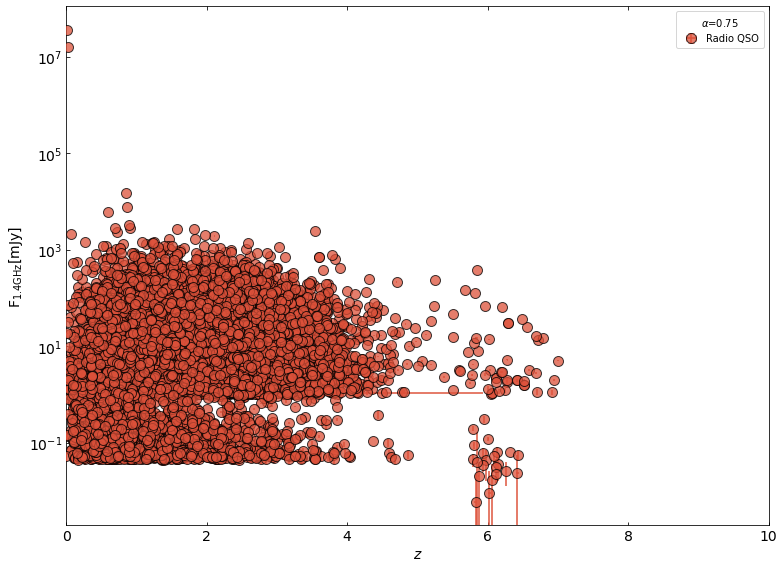

In [92]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, merged_flux_catalog_df['Flux 1.4-1.7 GHz'], xerr=redshift_e, yerr=F_20cm_e, marker='.',\
             ls='', color=colors[3], markersize=20, zorder=7, alpha=0.75, uplims=F_20cm_up_l, elinewidth=2,\
             mec='k', label='Radio QSO')
# ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[4],\
# markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

# ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz],\
# marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2,\
# mec='k', label='mm QSO')

# ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
# ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy', color=colors[1], path_effects=pe1)
# ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[2], path_effects=pe1)
# ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[3], path_effects=pe1)
# ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[4], path_effects=pe1)
# ax1.plot(z_range, lum_FIRST, label='FIRST (1 mJy)', color=colors[5], path_effects=pe1)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{F}_{1.4 \mathrm{GHz}} [\mathrm{mJy}]$', size=14)
ax1.set_yscale('log')
# ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


# ax2 = ax1.twinx()
# ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
# ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
# ax2.set_yscale('log')
# ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
# ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

We can see a very noticeable gap in our source distribution.
From the calculations in **Amarantidis et al., 2019**, we can explain this behavior  
from the selection biases of the different surveys involved in the production of our catalog. 

---

# Plot individual features

Another option to display the data is using histograms.  
From the selection of one column, we can create a plot.

<AxesSubplot:xlabel='Flux 1.4-1.7 GHz [mJy]', ylabel='Frequency'>

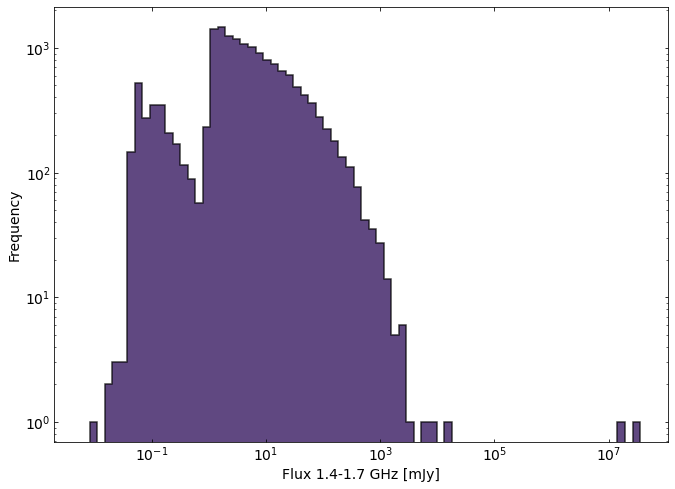

In [93]:
fig          = plt.figure(figsize=(11,8))
ax1          = fig.add_subplot(111)

col_name     = 'Flux 1.4-1.7 GHz'
col_name_str = col_name + ' [mJy]'

vmin_F       = np.log10(merged_flux_catalog_df[col_name].min())
vmax_F       = np.log10(merged_flux_catalog_df[col_name].max())
bins_F       = np.logspace(vmin_F, vmax_F, 75)

ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_xlabel(col_name_str, size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
merged_flux_catalog_df[col_name].plot.hist(color=colors[0], alpha=0.75, bins=bins_F, histtype='stepfilled', ec='k', lw=1.5)

For completeness, we can also create a histogram for the available redshift values.

<AxesSubplot:xlabel='$\\mathrm{redshift}$', ylabel='Frequency'>

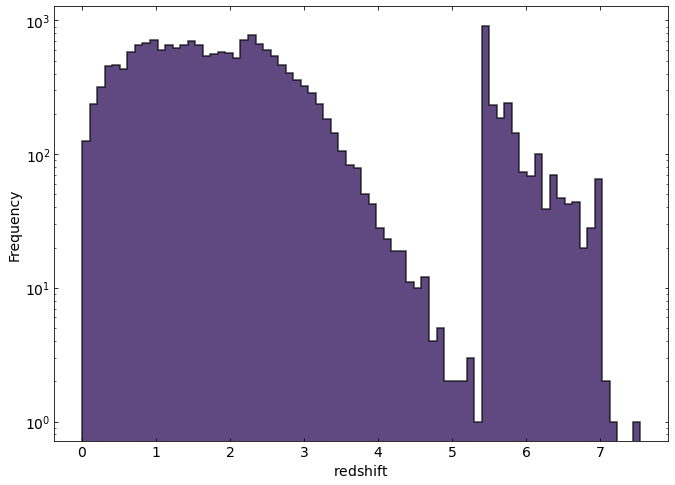

In [94]:
fig    = plt.figure(figsize=(11,8))
ax1    = fig.add_subplot(111)

vmin_z = redshift.min()
vmax_z = redshift.max()
bins_z = np.linspace(vmin_z, vmax_z, 75)

# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\mathrm{redshift}$', size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
redshift.plot.hist(color=colors[0], alpha=0.75, bins=bins_z, histtype='stepfilled', ec='k', lw=1.5)

We can also select two luminosity columns and plot them. We can color-code them by redshift  
and include histograms for both quantities.

In [95]:
flux_names          = merged_flux_catalog_df.columns

In [96]:
add_histograms_flag = True  # Add histograms to the folowing plot

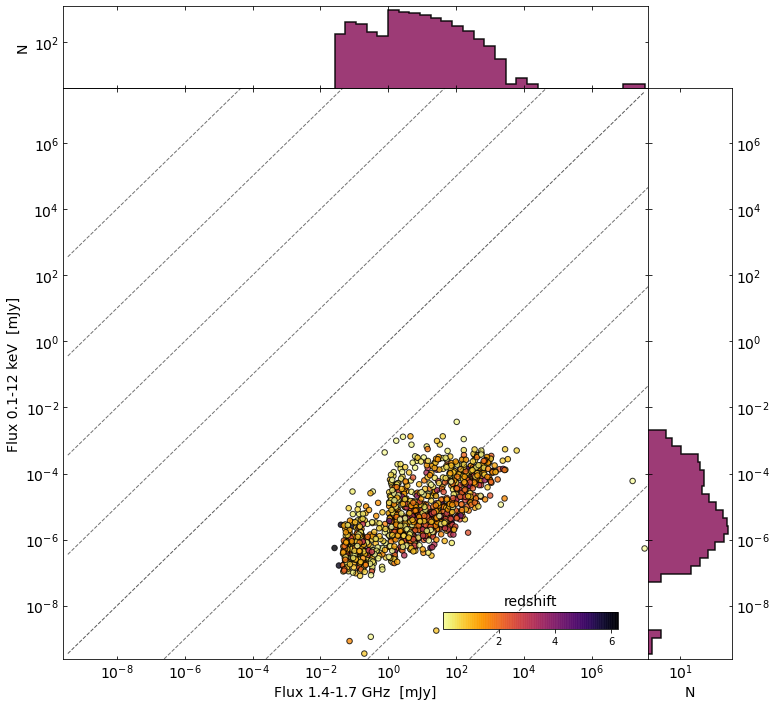

In [97]:
fig        = plt.figure(figsize=(12,12))

if not add_histograms_flag:
    ax1    = fig.add_subplot(111)

if add_histograms_flag:
    ax1    = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2    = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3    = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by number
# col_a = lum_names[0]
# col_b = lum_names[23]

# Select columns by name
col_a       = "Flux 1.4-1.7 GHz"
col_b       = "Flux 0.1-12 keV"

# Obtain luminosities and the cross-match between them
flux_a      = merged_flux_catalog_df[col_a]
flux_b      = merged_flux_catalog_df[col_b]
common_vals = np.multiply(flux_a, flux_b)

# Create log bins for log-scale histograms
min_val     = np.nanmin([flux_a[np.isfinite(common_vals)].min(), flux_b[np.isfinite(common_vals)].min()])
max_val     = np.nanmax([flux_a[np.isfinite(common_vals)].max(), flux_b[np.isfinite(common_vals)].max()])
bins_a      = np.logspace(np.log10(flux_a[np.isfinite(common_vals)].values.min()), np.log10(flux_a[np.isfinite(common_vals)].values.max()), 30)
bins_b      = np.logspace(np.log10(flux_b[np.isfinite(common_vals)].values.min()), np.log10(flux_b[np.isfinite(common_vals)].values.max()), 30)

ax1.set_yscale('log')
ax1.set_xscale('log')

# Format axis names and limits
if 'FLUX_' in col_a:
    col_a   = col_a.replace('FLUX_', 'Flux ') + ' (SIMBAD)'
if 'FLUX_' in col_b:
    col_b   = col_b.replace('FLUX_', 'Flux ') + ' (SIMBAD)'
ax1.set_xlabel(col_a + '  [mJy]', size=14)
ax1.set_ylabel(col_b + '  [mJy]', size=14)
ax1.set_ylim(min_val*0.7, max_val*1.3)
ax1.set_xlim(min_val*0.7, max_val*1.3)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)

sc          = ax1.scatter(flux_a, flux_b, c=redshift, cmap='inferno_r', s=30, alpha=0.80, edgecolor='black')

# Add 1-1 line and parallels for comparison
ax1.plot([min_val, max_val], [min_val, max_val], ls='dashed', color='k', alpha=0.65, lw=1)
for factor in [1e3, 1e6, 1e9, 1e12]:
    ax1.plot([min_val, max_val], [min_val*factor, max_val*factor], ls='dashed', color='k', alpha=0.55, lw=1)
    ax1.plot([min_val, max_val*factor], [min_val/factor, max_val], ls='dashed', color='k', alpha=0.55, lw=1)

# Create colorbar and plot it
cbaxes      = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
clb         = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# clb.set_label('redshift', size=14)
clb.ax.set_title('redshift', size=14)

ax1.set_aspect('auto', share=False, adjustable='box')

if add_histograms_flag:
    # Plot vertical histogram
    hist(flux_b.values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color,\
         ec='k', lw=1.5, hatch='')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('N', size=14)
    
    # Plot horizontal histogram
    hist(flux_a.values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color,\
         ec='k', lw=1.5, hatch='')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel('N', size=14)
    
    # Modify ticks
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
    ax3.tick_params(which='both',top=True, right=True, direction='in')
    
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

---

# Obtain most highly correlated quantities

Make use of tools from `pandas` to calculate correlations between  
the flux columns and find the highest values.  
Pandas default behavior calculates the Pearson correlation coefficient (Kendall Tau and Spearman coefficients are also available).  
Since we do not know the exact behavior of our features, we choose Spearman's correlation coefficient.  
It is a non-parametric test that assesses monotonic relationships (something more general than linear  
relationships, as Pearson's does).

An interesting by-product of favoring Spearman over Pearson is that, since we are, mostly,  
visualizing our data in logarithmic scale, not only linear correlations can be spotted easily.  
Thus, what we can see (graphically) can match better the correlation values.

We can choose how many elements (sources) can be used for calculations. In our case,  
we want to use all of them.

It is also possible to avoid correlation calculations for columns with too few  
elements. The variable `min_elements` has been set to $20$ to this end.

In [98]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols    = 534    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements   = 20
# corr           = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr           = merged_flux_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs       = corr.abs()

In the following code block, the names of the pairs of columns with the  
highest correlations (and their values) are retrieved.

In [99]:
cols_corr      = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

It is recommended to drop (not using) columns with correlation values too close to one  
($1.0$) as they do not add new information to the analysis. The variable `corr_thresh` will  
limit the correlation values which will be discarded. In general, values above $0.7$ should  
be discarded. But, since we want to explore any possible correlation between our measurements,  
we can keep a higher value. As a matter of fact, we do want to discover these correlations.

The variable `num_of_corr` selects the number of high correlation pairs of columns we want to analyze at a time.  
This is purely for visualization purposes.

In [100]:
corr_thresh    = 0.90  # We want pairs with correlations below this value (0.78, 0.98, etc.)
num_of_corr    = 50    # How many high correlations we want to analyze at a time

In [101]:
arr_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [102]:
cols_corr[cols_corr<corr_thresh][:num_of_corr]

Flux I                Flux r                  0.897712
Flux g                Flux u                  0.889493
Flux 10-38 MHz        Flux 111-178 MHz        0.888022
                      Flux 60-86 MHz          0.886718
Flux r                Flux g                  0.886482
Flux 7.7-17 GHz       Flux 20-44 GHz          0.885942
Flux i                Flux g                  0.881278
                      Flux V                  0.876153
Flux 111-178 MHz      Flux 1.4-1.7 GHz        0.871233
Flux 203-375 GHz      Flux 0.1-12 keV         0.844943
Flux 60-100 microns   Flux 10-30 microns      0.840952
Flux 20-44 GHz        Flux 61-77 GHz          0.835577
Flux 1.4-1.7 GHz      Flux 7.7-17 GHz         0.823726
Flux g                Flux B                  0.822688
                      Flux FUV                0.817526
Flux V                Flux u                  0.813623
Flux 10-38 MHz        Flux 230-468 MHz        0.812710
Flux 60-86 MHz        Flux 230-468 MHz        0.810975
Flux 2.2-5

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

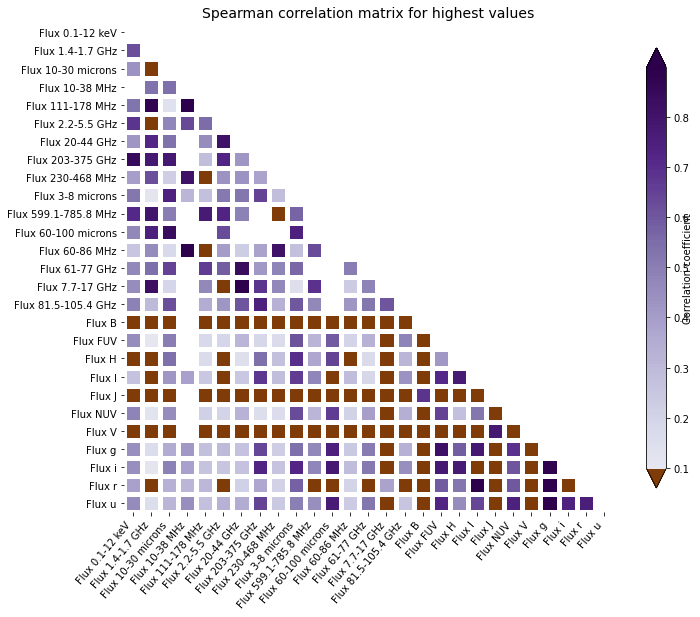

In [103]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr.loc[cols_high_corr, cols_high_corr], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr.loc[cols_high_corr, cols_high_corr].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=0.1, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr.tolist()),1)
ax1.set_xticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

To compare these results, we can calculate the correlation matrix using Pearson's  
coefficient.

In [104]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
min_elements   = 20

corr_alt       = merged_flux_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_alt_abs   = corr_alt.abs()

Names of the pairs of columns with the  
highest correlations (and their values).

In [105]:
# Pairs of columns with the highest correlations
cols_alt_corr  = (corr_alt_abs.where(np.triu(np.ones(corr_alt_abs.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [106]:
# Columns involved in the highest 25 correlations (below 0.75)
arr_alt_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])
# Array with individual column names from highest correlations
cols_high_corr_alt = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))

We can show a sample of the highly correlated pairs of columns.

In [107]:
cols_alt_corr[cols_alt_corr<corr_thresh][:num_of_corr]

Flux 230-468 MHz      Flux 1.4-1.7 GHz        0.895642
Flux 7.7-17 GHz       Flux 20-44 GHz          0.895259
Flux K                Flux J                  0.880698
Flux 1.4-1.7 GHz      Flux 2.2-5.5 GHz        0.866403
Flux r                Flux u                  0.851348
Flux 81.5-105.4 GHz   Flux 203-375 GHz        0.847459
Flux 60-86 MHz        Flux 230-468 MHz        0.829305
Flux i                Flux g                  0.823149
Flux 111-178 MHz      Flux 1.4-1.7 GHz        0.806905
Flux 61-77 GHz        Flux 203-375 GHz        0.802162
Flux 150-500 microns  Flux 60-100 microns     0.799650
Flux 7.7-17 GHz       Flux 81.5-105.4 GHz     0.794312
Flux 2.2-5.5 GHz      Flux 20-44 GHz          0.790535
Flux 81.5-105.4 GHz   Flux H                  0.779757
Flux 599.1-785.8 MHz  Flux 2.2-5.5 GHz        0.774137
Flux 7.7-17 GHz       Flux 203-375 GHz        0.770961
Flux 60-86 MHz        Flux 599.1-785.8 MHz    0.763523
Flux 7.7-17 GHz       Flux 61-77 GHz          0.762911
Flux 61-77

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

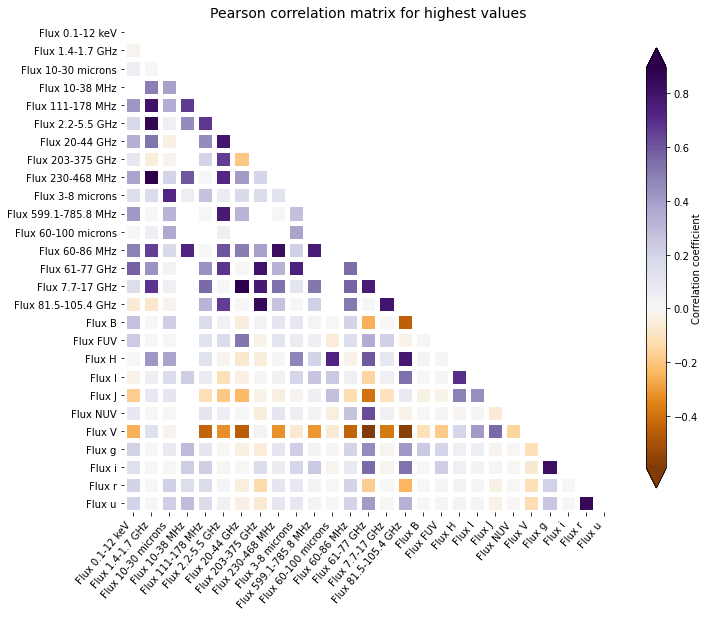

In [108]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr_alt.tolist()),1)
ax1.set_xticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Assess blank spaces

For future calculations, and given the large amount of blank spaces seen in  
the correlation matrix plot, we also want to understand the level of sparsity of our sample.  
We use the package `missingno` to represent how many values are missing  
in our catalog.

First, we calculate the level of *completeness* (how many sources have valid measurements) of each column for the whole dataset.

<AxesSubplot:>

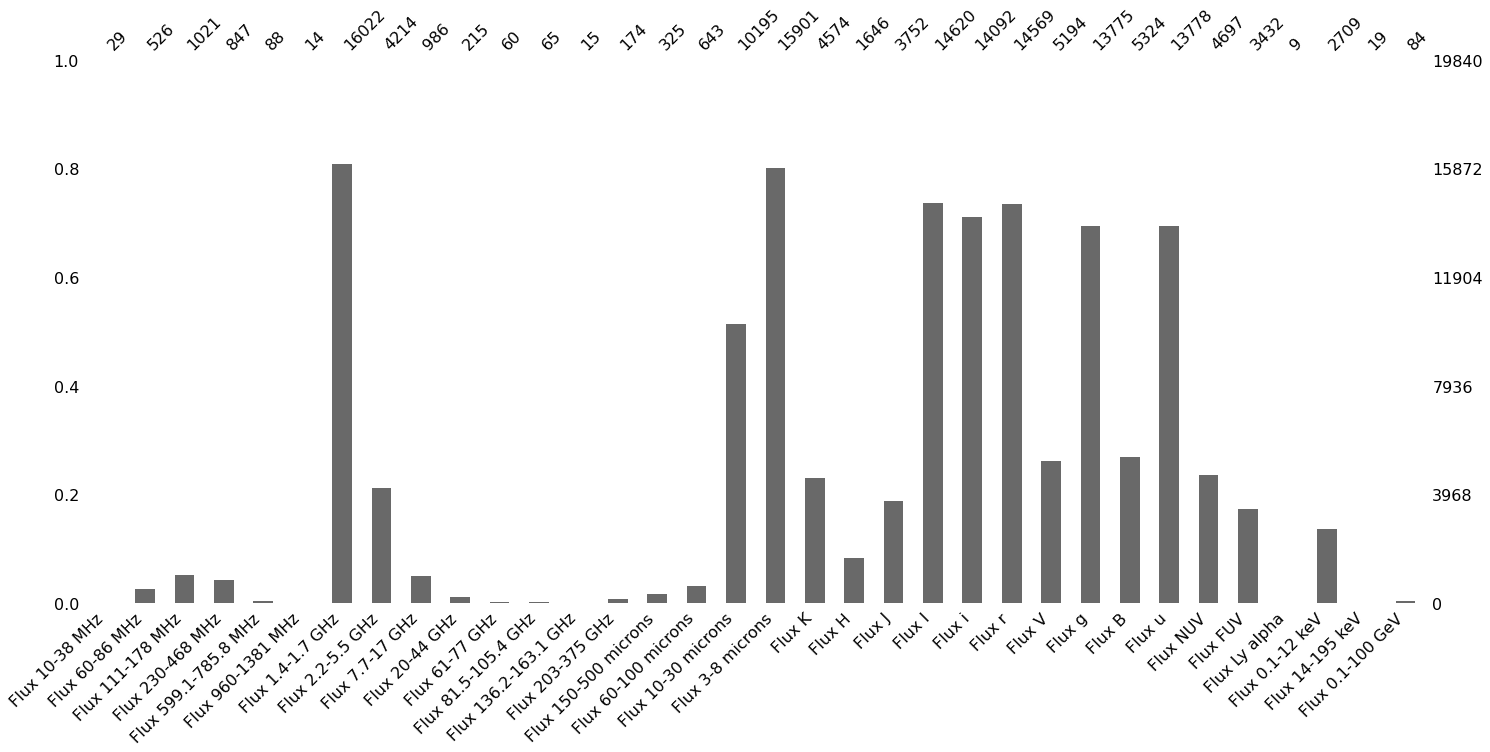

In [109]:
# msno.matrix(merged_lums_catalog_df)
msno.bar(merged_flux_catalog_df)

Now, we do it for only the most highly correlated columns.

In [110]:
# used_data = pd.DataFrame(merged_flux_catalog_df[cols_high_corr])
used_data = pd.DataFrame(merged_flux_catalog_df)

<AxesSubplot:>

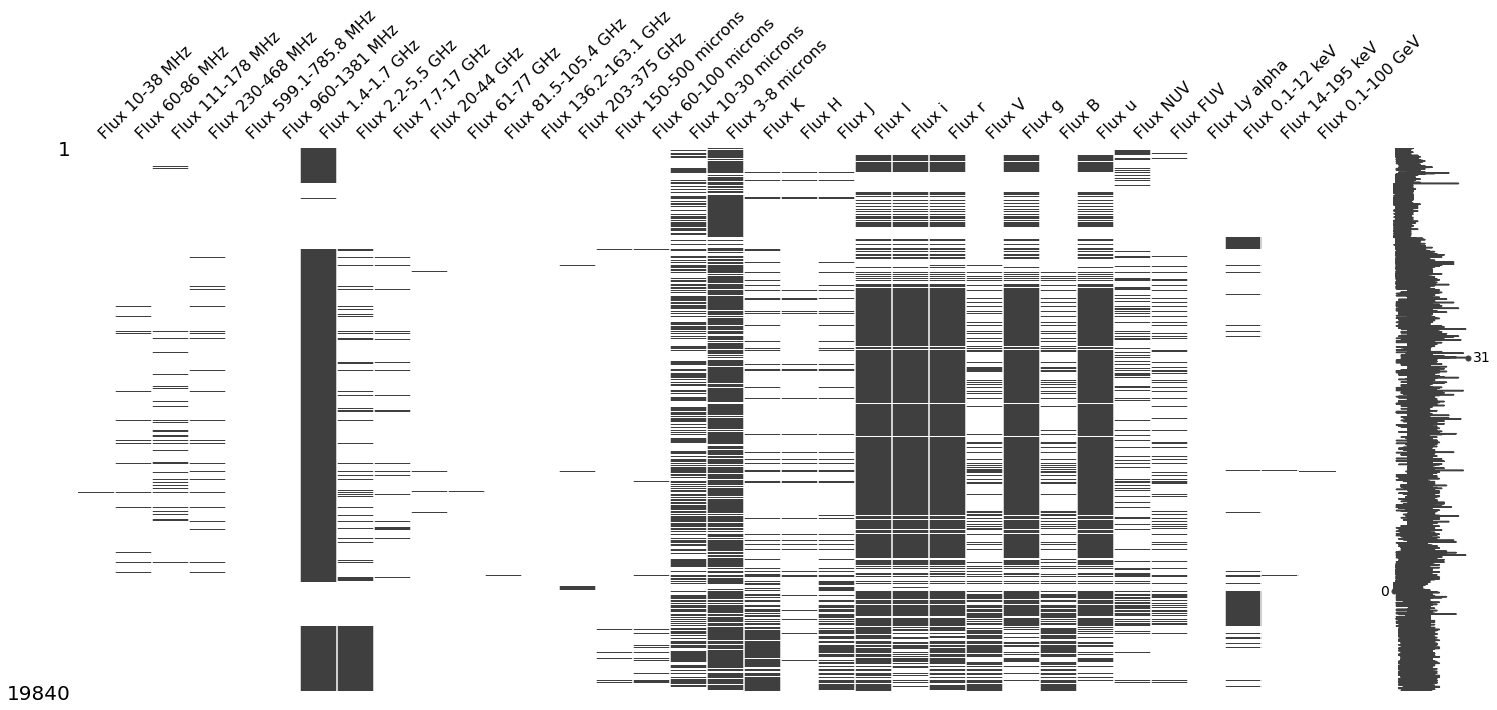

In [111]:
msno.matrix(used_data)

The right-most column in the chart shows the general shape of the data *completeness* of each selected row.  
It also points out the rows with the maximum and minimum nullity in the dataset.

This package allows us also to plot how correlated are the correlated behaviors  
of absence or presence of data for pairs of columns. A dendrogram can be plotted to  
understand any correlation in the lack of data.

In [112]:
# msno.dendrogram(merged_flux_catalog_df[cols_high_corr])

Numerically, we can also show the percentage of values in each column populated with NaN values.

For the columns with less invalid values, we have:

In [113]:
(merged_flux_catalog_df.isnull().sum()/len(merged_flux_catalog_df)*100).sort_values(ascending=True)[:25]

Flux 1.4-1.7 GHz        19.243952
Flux 3-8 microns        19.853831
Flux I                  26.310484
Flux r                  26.567540
Flux i                  28.971774
Flux u                  30.554435
Flux g                  30.569556
Flux 10-30 microns      48.613911
Flux B                  73.165323
Flux V                  73.820565
Flux NUV                76.325605
Flux K                  76.945565
Flux 2.2-5.5 GHz        78.760081
Flux J                  81.088710
Flux FUV                82.701613
Flux 0.1-12 keV         86.345766
Flux H                  91.703629
Flux 111-178 MHz        94.853831
Flux 7.7-17 GHz         95.030242
Flux 230-468 MHz        95.730847
Flux 60-100 microns     96.759073
Flux 60-86 MHz          97.348790
Flux 150-500 microns    98.361895
Flux 20-44 GHz          98.916331
Flux 203-375 GHz        99.122984
dtype: float64

And, for the features with the highest number of invalid entries:

In [114]:
# (merged_flux_catalog_df.isnull().sum()/len(merged_flux_catalog_df)*100).sort_values(ascending=True)[-25:]

---

# Impute empty values

Given the large proportion of empty (`NaN`) values in our dataset, we want to modify  
our table in order to make it easier to be analyzed by clustering algorithms or other type of ML codes.

Thus, we can replace non-numeric elements with some value. In this case, we choose zero ($0$) or $-99$ (as it is a very unlikely value in this context).

In [115]:
# backup_filled_flux_cat_df = filled_lums_cat_df.copy()
# filled_flux_cat_df = merged_flux_catalog_df.dropna(axis='columns', how='all')
# filled_flux_cat_df = filled_flux_cat_df.fillna(0)
# filled_flux_cat_df = filled_flux_cat_df.replace('inf', 0)

We can, also, replace the missing values with the mean of the selected column.

First, we discard columns containing less than one element.  
Some columns might have similar data (similar observational properties) and  
discarding before combining (in some way) them might have an impact in further calculations.

In [116]:
# filled_flux_cat_df = merged_flux_catalog_df.dropna(axis='columns', how='all')
filled_flux_cat_df = merged_flux_catalog_df.dropna(axis='columns', thresh=20)
col_names_non_drop = filled_flux_cat_df.columns

It is important to keep in mind that columns which have all their values as NaN  
might still have upper limits. These values have not been taken into account in this study.

Now, we replace the missing values.

In [117]:
# imputer       = SimpleImputer(missing_values=np.nan, strategy='median')
imputer       = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-99.00)
imputed_array = imputer.fit_transform(filled_flux_cat_df, filled_flux_cat_df)

Reassing the new (replaced) data into the old Table

In [118]:
filled_flux_cat_df = pd.DataFrame(imputed_array, columns=col_names_non_drop)

---

In [119]:
np.shape(merged_flux_catalog_df.columns)

(34,)

In [120]:
np.shape(filled_flux_cat_df.columns)

(30,)

---

# Recreate correlation matrix

Now, we can repeat parts of the previous procedures with our data.

The option `min_elements` tells the code to obtain the correlation matrix  
only for pairs of columns with more than this number of elements in common.

In [121]:
num_of_rows      = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols      = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements     = 20
# corr             = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled      = filled_flux_cat_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled  = corr_filled.abs()

Ordered list of highly correlated pairs of columns.

In [122]:
cols_corr_filled = (corr_abs_filled.where(np.triu(np.ones(corr_abs_filled.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [123]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [124]:
arr_cols_filled       = np.array([np.array(row) for row in cols_corr_filled.keys()[cols_corr_filled<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled = np.unique(np.concatenate((arr_cols_filled[:, 0], arr_cols_filled[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [125]:
cols_corr_filled[cols_corr_filled<corr_thresh][:num_of_corr]

Flux i                Flux r                 0.887853
                      Flux u                 0.887258
Flux r                Flux g                 0.868079
Flux K                Flux J                 0.855187
Flux I                Flux g                 0.848521
Flux r                Flux u                 0.816795
Flux 10-30 microns    Flux 3-8 microns       0.805199
Flux I                Flux u                 0.796127
Flux 61-77 GHz        Flux 81.5-105.4 GHz    0.677411
Flux 60-86 MHz        Flux 230-468 MHz       0.661221
Flux H                Flux J                 0.658105
Flux K                Flux H                 0.637851
Flux 2.2-5.5 GHz      Flux 7.7-17 GHz        0.610889
Flux 150-500 microns  Flux 60-100 microns    0.604072
Flux B                Flux FUV               0.601011
Flux V                Flux FUV               0.590968
Flux K                Flux V                 0.546184
Flux J                Flux V                 0.544842
Flux r                Flux B

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

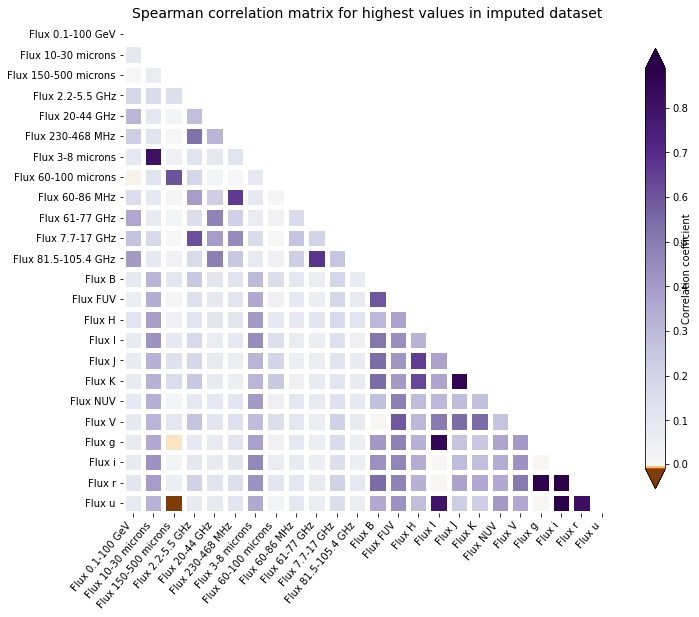

In [126]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled]
# arr_corr_filled[(arr_corr_filled > corr_thresh) & (arr_corr_filled < 1)] = 0
# arr_corr_filled[(arr_corr_filled < -corr_thresh) & (arr_corr_filled > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].mask(mask_corr)
arr_corr_filled[arr_corr_filled > corr_thresh] = 0
arr_corr_filled[arr_corr_filled < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled[arr_corr_filled > -1].values)
vmax      = np.nanmax(arr_corr_filled[arr_corr_filled < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled, cmap='PuOr', norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(cols_high_corr_filled.tolist()),1)
ax1.set_xticks(np.arange(arr_corr_filled.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values in imputed dataset', size=14)

ax1.set_aspect('equal')

Another change we can make is related to the position of the columns in the correlation matrix.  
It is possible to change their order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [127]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [128]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [129]:
X                      = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].values
d                      = hc.distance.pdist(X)
L                      = hc.linkage(d, method='complete')
ind                    = hc.fcluster(L, 0.5*d.max(), 'distance')
ordered_columns_filled = [corr_filled[cols_high_corr_filled].columns.tolist()[i] for i in list((np.argsort(ind)))]
corr_filled_ordered    = corr_filled[cols_high_corr_filled].reindex(columns=ordered_columns_filled)
corr_filled_ordered    = corr_filled_ordered.reindex(index=ordered_columns_filled)

Now, we can replot the newly ordered correlation matrix.

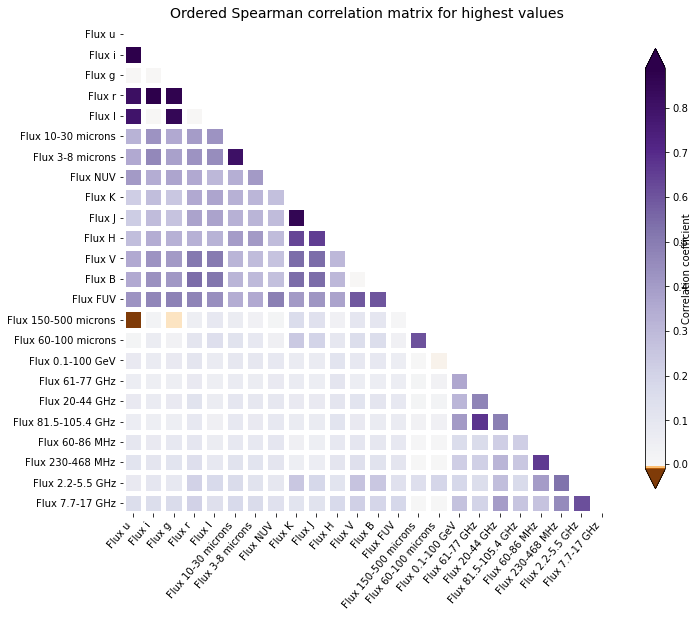

In [130]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled].mask(mask_corr)
arr_corr_filled_ordered[arr_corr_filled_ordered > corr_thresh] = 0
arr_corr_filled_ordered[arr_corr_filled_ordered < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered[arr_corr_filled_ordered > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered[arr_corr_filled_ordered < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered, cmap='PuOr', norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Ordered Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Analyze feature relevance

Since the number of features our dataset has is high, we want to study their behavior  
in order to drop some of these features. Some algorithms have been developed to assess  
the importance of the information contained by each feature in the context of the overall  
behavior of the full sample.

A relevant measure of the quality of the variables (columns) we use has to do with  
their variance (or standard deviation). The differences between the variances among the columns  
should not be too high. When one column has too low variance, it does not add extra information  
to the overall table.

We can calculate the variances for all the columns.

In [131]:
order_variance        = filled_flux_cat_df.var().sort_values(ascending=False)
cols_ordered_variance = order_variance.index

Show the first $10$ elements.

In [132]:
order_variance[:10]

Flux FUV                7.232359e+23
Flux NUV                6.648484e+21
Flux B                  9.495257e+20
Flux 10-30 microns      8.914401e+20
Flux i                  8.267389e+20
Flux g                  3.367739e+20
Flux r                  5.853571e+19
Flux u                  1.630705e+19
Flux 150-500 microns    1.526016e+18
Flux 81.5-105.4 GHz     1.270182e+15
dtype: float64

Show the last $10$ elements.

In [133]:
order_variance[-10:]

Flux 60-100 microns    7805.002084
Flux 61-77 GHz         6827.371810
Flux V                 2740.052665
Flux K                 2108.453818
Flux I                 1992.399380
Flux J                 1953.969853
Flux 3-8 microns       1574.098640
Flux 0.1-12 keV        1155.582249
Flux H                  766.085101
Flux 0.1-100 GeV         41.322563
dtype: float64

These results can be seen graphically with the help of the Principal Component Analysis (`PCA`) algorithm.

In [134]:
pca = PCA()
pca.fit_transform(filled_flux_cat_df)
pca_variance = pca.explained_variance_

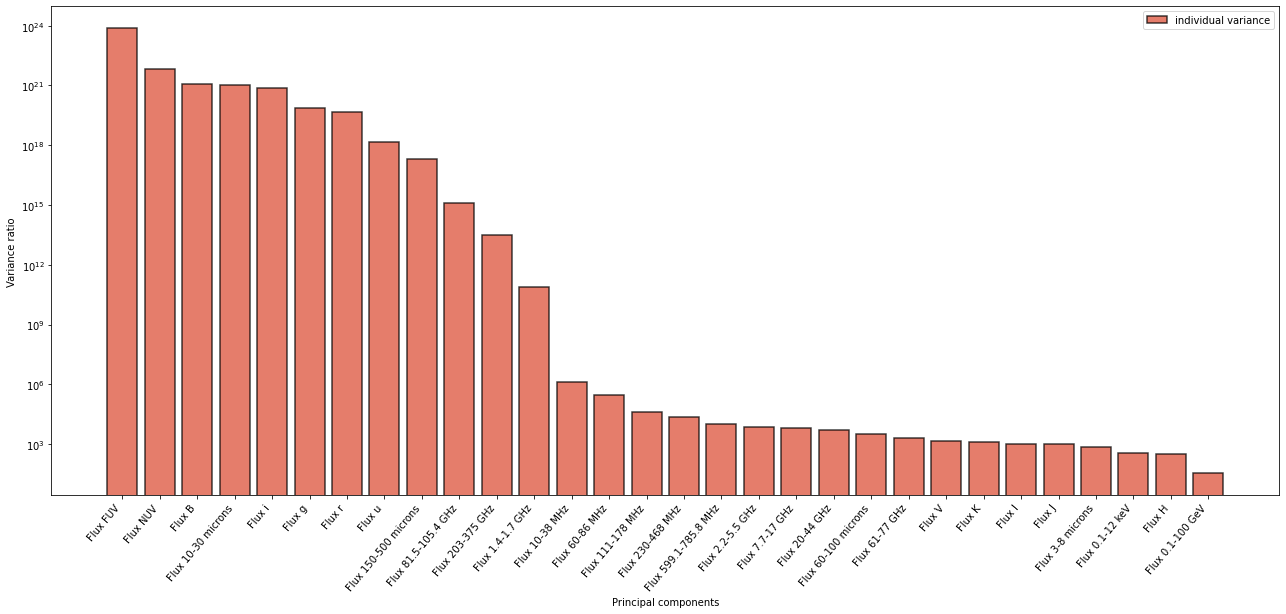

In [135]:
fig = plt.figure(figsize=(22,9))
ax1 = fig.add_subplot(111)

plt.bar(range(np.shape(cols_ordered_variance)[0]), pca_variance, alpha=0.75, align='center',\
        label='individual variance', color=colors[3], edgecolor='k', lw=1.5)
plt.legend()
ax1.set_ylabel('Variance ratio')
ax1.set_xlabel('Principal components')
ax1.set_yscale('log')
ticks = np.arange(0,len(cols_ordered_variance),1);
ax1.set_xticks(ticks);
ax1.set_xticklabels(cols_ordered_variance, rotation=50, horizontalalignment='right');

It can be seen that most of the variance of the dataset is explained by ten features  
(`FUV`, `NUV`, `i`, `10-30 microns`, `g`, `r`, `150-500 microns`, `B`, `u`, `203-375 GHz`).  
The rest of features show variance values orders of magnitude lower (including `1.4-1.7 GHz`).

---

# Remove highly correlated features

We can remove the features which do not add extra information to our dataset.  
This can be achieved taking the most highly correlated pairs of columns and  
discarding the feature with the lowest variance (i.e., the least relevant feature).

Another reason to explore these features is that they might have too similar values.  
This can be an expression of the imputation of missing values since many entries  
show the same value (if the imputation has been applied with a constant value for all columns).

In [136]:
high_corr_thresh            = 0.95

In [137]:
high_corr_pairs             = cols_corr_filled[cols_corr_filled > high_corr_thresh]  # Already discarded self correlations

In [138]:
filled_flux_clean_df        = filled_flux_cat_df.copy()

cols_high_corr_filled_clean = np.unique(high_corr_pairs.index.tolist()).tolist()

In [139]:
cols_high_corr_filled_clean

[]

In [140]:
np.shape(cols_high_corr_filled_clean)

(0,)

We will not remove these features for this moment.  
We want to keep all data for possible meaningful relations.

In [141]:
remove_correlated_flag = False

In [142]:
if remove_correlated_flag:
    for pair in high_corr_pairs.index.to_list():
        col_a, col_b = pair
        if col_a not in cols_high_corr_filled_clean or col_b not in cols_high_corr_filled_clean: continue
        var_a = order_variance[col_a]
        var_b = order_variance[col_b]
        if var_a < var_b:
            filled_flux_clean_df.drop(col_a, inplace=True, axis='columns')
            cols_high_corr_filled_clean.remove(col_a)
            print('Removed column: ' + col_a)
        else:
            filled_flux_clean_df.drop(col_b, inplace=True, axis='columns')
            cols_high_corr_filled_clean.remove(col_b)
            print('Removed column: ' + col_b)

In [143]:
filled_flux_clean_df.shape

(19840, 30)

In [144]:
np.shape(cols_high_corr_filled_clean)

(0,)

Thus, we have removed $1$ feature from our dataset.  
Our sample now displays $22$ features.

---

# Repeat previous calculations

Now, we can obtain the correlation matrix and all its by-products  
as previously shown.

In [145]:
num_of_rows            = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols            = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements           = 20
# corr                   = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean      = filled_flux_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled_clean  = corr_filled_clean.abs()

Ordered list of highly correlated pairs of columns.

In [146]:
cols_corr_filled_clean = (corr_abs_filled_clean.where(np.triu(np.ones(corr_abs_filled_clean.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [147]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [148]:
arr_cols_filled_clean       = np.array([np.array(row) for row in cols_corr_filled_clean.keys()[cols_corr_filled_clean<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean = np.unique(np.concatenate((arr_cols_filled_clean[:, 0], arr_cols_filled_clean[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [149]:
cols_corr_filled_clean[cols_corr_filled_clean<corr_thresh][:num_of_corr]

Flux i                Flux r                 0.887853
                      Flux u                 0.887258
Flux r                Flux g                 0.868079
Flux K                Flux J                 0.855187
Flux I                Flux g                 0.848521
Flux r                Flux u                 0.816795
Flux 10-30 microns    Flux 3-8 microns       0.805199
Flux I                Flux u                 0.796127
Flux 61-77 GHz        Flux 81.5-105.4 GHz    0.677411
Flux 60-86 MHz        Flux 230-468 MHz       0.661221
Flux H                Flux J                 0.658105
Flux K                Flux H                 0.637851
Flux 2.2-5.5 GHz      Flux 7.7-17 GHz        0.610889
Flux 150-500 microns  Flux 60-100 microns    0.604072
Flux B                Flux FUV               0.601011
Flux V                Flux FUV               0.590968
Flux K                Flux V                 0.546184
Flux J                Flux V                 0.544842
Flux r                Flux B

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

Change directlu the column order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [150]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [151]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [152]:
X_clean                      = corr_filled_clean.loc[cols_high_corr_filled_clean, cols_high_corr_filled_clean].values
d_clean                      = hc.distance.pdist(X_clean)
L_clean                      = hc.linkage(d_clean, method='complete')
ind_clean                    = hc.fcluster(L_clean, 0.5*d_clean.max(), 'distance')
ordered_columns_filled_clean = [corr_filled_clean[cols_high_corr_filled_clean].columns.tolist()[i] for i in list((np.argsort(ind_clean)))]
corr_filled_ordered_clean    = corr_filled_clean[cols_high_corr_filled_clean].reindex(columns=ordered_columns_filled_clean)
corr_filled_ordered_clean    = corr_filled_ordered_clean.reindex(index=ordered_columns_filled_clean)

Now, we can replot the newly ordered correlation matrix.

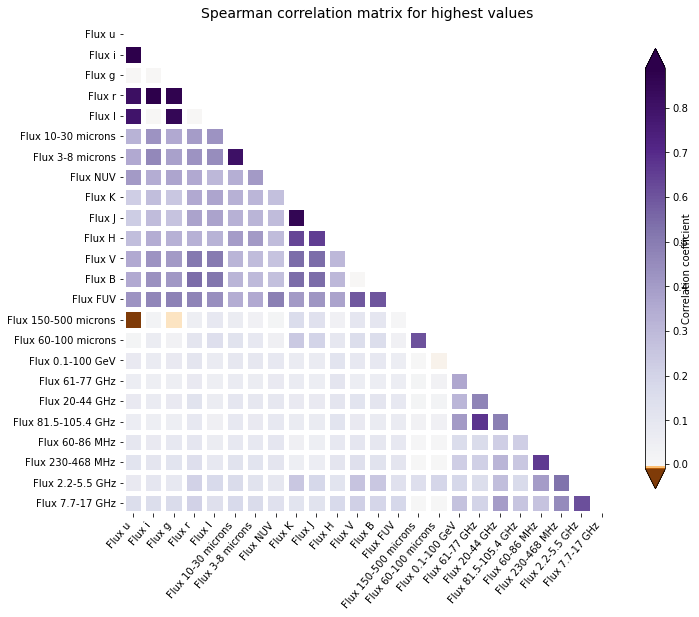

In [153]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean = corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean].mask(mask_corr)
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > corr_thresh] = 0
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean, cmap='PuOr', norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

Comparing that to the use of Pearson correlation values.

In [154]:
num_of_rows                = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols                = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements               = 20
# corr                       = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean_alt      = filled_flux_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_abs_filled_clean_alt  = corr_filled_clean_alt.abs()

Ordered list of highly correlated pairs of columns.

In [155]:
cols_corr_filled_clean_alt = (corr_abs_filled_clean_alt.where(np.triu(np.ones(corr_abs_filled_clean_alt.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [156]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [157]:
arr_cols_filled_clean_alt       = np.array([np.array(row) for row in\
                                            cols_corr_filled_clean_alt.keys()[cols_corr_filled_clean_alt<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean_alt = np.unique(np.concatenate((arr_cols_filled_clean_alt[:, 0], arr_cols_filled_clean_alt[:, 1])))  # Array with individual column names from highest correlations

In [158]:
X_clean_alt                      = corr_filled_clean_alt.loc[cols_high_corr_filled_clean_alt, cols_high_corr_filled_clean_alt].values
d_clean_alt                      = hc.distance.pdist(X_clean_alt)
L_clean_alt                      = hc.linkage(d_clean_alt, method='complete')
ind_clean_alt                    = hc.fcluster(L_clean_alt, 0.5*d_clean_alt.max(), 'distance')
ordered_columns_filled_clean_alt = [corr_filled_clean_alt[cols_high_corr_filled_clean_alt].columns.tolist()[i] for i in\
                                    list((np.argsort(ind_clean_alt)))]
corr_filled_ordered_clean_alt    = corr_filled_clean_alt[cols_high_corr_filled_clean_alt].reindex(columns=ordered_columns_filled_clean_alt)
corr_filled_ordered_clean_alt    = corr_filled_ordered_clean_alt.reindex(index=ordered_columns_filled_clean_alt)

Now, we can replot the newly ordered correlation matrix.

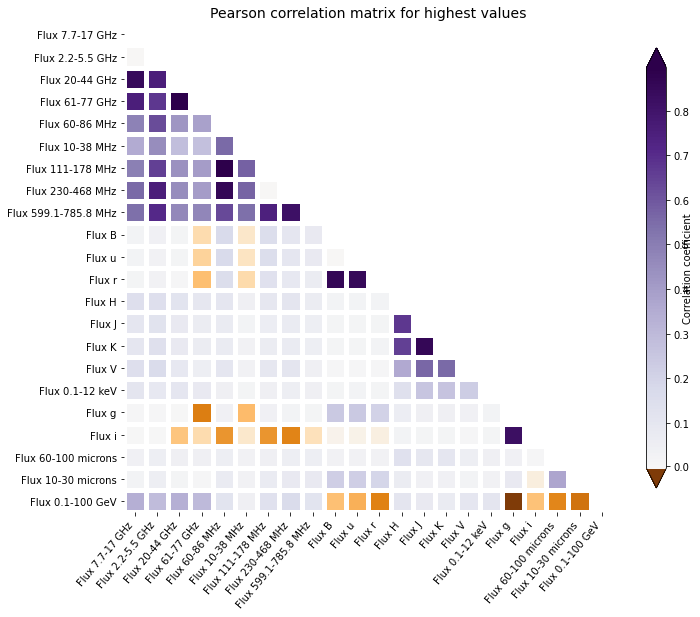

In [159]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt,\
                                                                   ordered_columns_filled_clean_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean_alt = corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt,\
                                                                      ordered_columns_filled_clean_alt].mask(mask_corr)
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > corr_thresh] = 0
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean_alt, cmap='PuOr', norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean_alt),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Clustering calculations

As a way to extend our analysis, we can construct, and plot, the dendrogram for our data.  
This tool can be useful to determine possible clustering among the columns.

We are going to use the table with imputed values and with highly correlated features removed.

In [160]:
# generate the linkage matrix
Z = hc.linkage(filled_flux_clean_df, 'ward')

We plot a reduced version of the dendrogram.

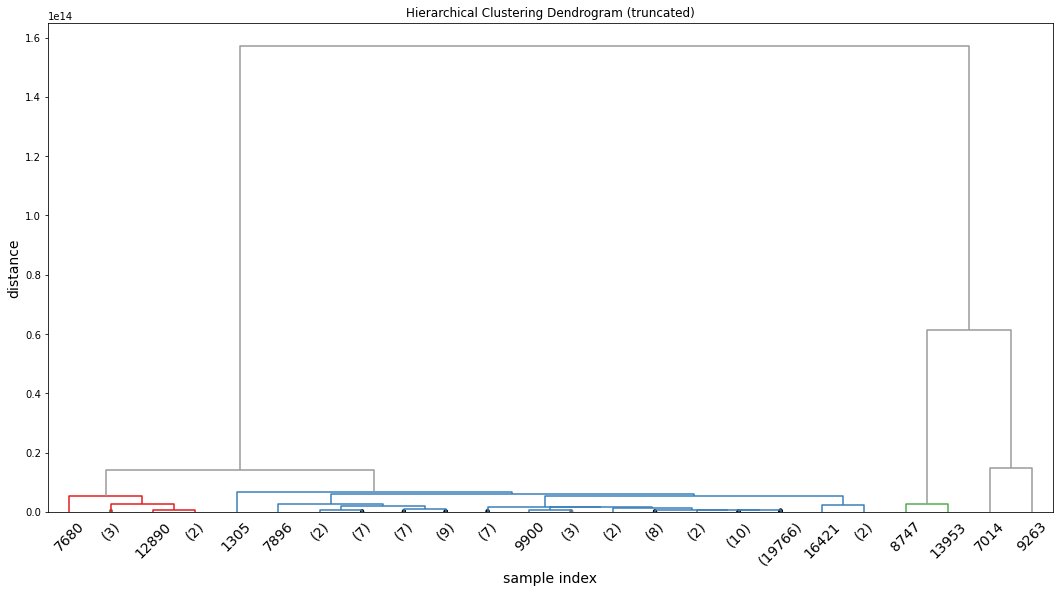

In [161]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(111)

# Custom color for branches
cmap_use   = cm.get_cmap('Set1')
cmap_array = cmap_use(np.linspace(0, 1, 10))
hc.set_link_color_palette([mcolors.rgb2hex(rgb[:3]) for rgb in cmap_array])

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index', size=14)
plt.ylabel('distance', size=14)
hc.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    # leaf_rotation=90.,
    color_threshold =0.1e14,
    above_threshold_color=cmap_use(1.0),  # color of first link
    leaf_font_size=14.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    orientation='top'
)

#plt.xscale('log')
plt.show()

# hc.set_link_color_palette(None)  # Reset color values

If we attempt to remove the four sources which are at the longest distances from the main *cluster*, that is,  
the elements not in blue and the first source in blue (`id:2286`), we obtain the following diagram.

In [162]:
filled_flux_clean_df_close = filled_flux_clean_df.drop([8747, 13953, 7014, 9263], axis='index')

In [163]:
# generate the linkage matrix
Z_close = hc.linkage(filled_flux_clean_df_close, 'ward')

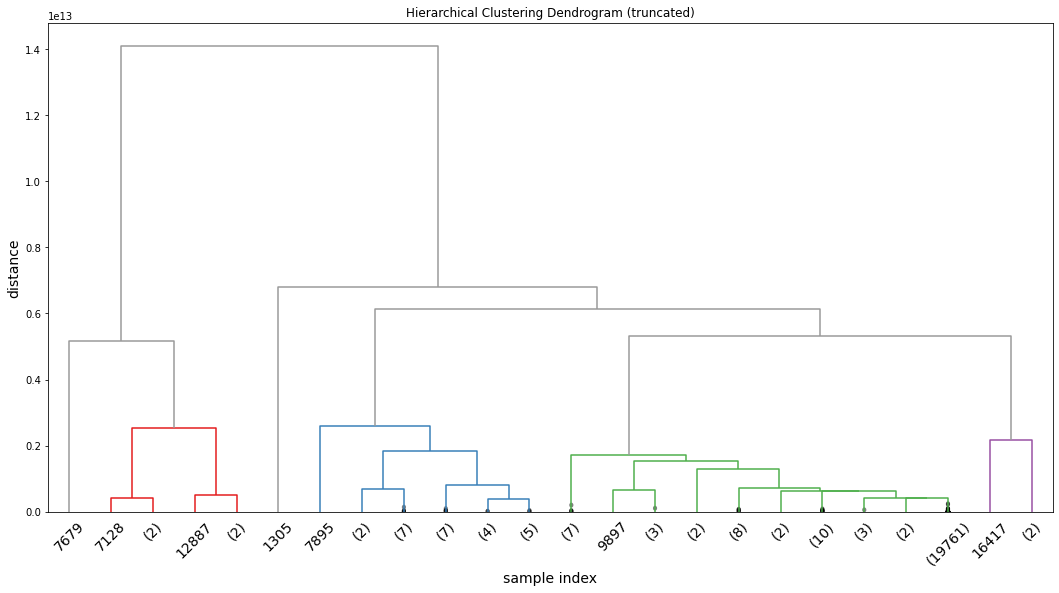

In [164]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(111)

# Custom color for branches
cmap_use   = cm.get_cmap('Set1')
cmap_array = cmap_use(np.linspace(0, 1, 10))
hc.set_link_color_palette([mcolors.rgb2hex(rgb[:3]) for rgb in cmap_array])

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index', size=14)
plt.ylabel('distance', size=14)
hc.dendrogram(
    Z_close,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    # leaf_rotation=90.,
    color_threshold =3e12,
    above_threshold_color=cmap_use(1.0),  # color of first link
    leaf_font_size=14.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    orientation='top'
)

#plt.xscale('log')
plt.show()

# hc.set_link_color_palette(None)  # Reset color values

One conclusion that can be drawn from the previous dendrogram is related to  
the fact that the most part of our sample is shown as part of one major cluster  
and the remaining elements are depicted as, mostly, outliers (distributed in two minor subsets).

Another option to find possible clusters within our data is using `t-SNE`  
(t-distributed Stochastic Neighbor Embedding, **van der Maaten and Hinton, 2008**) algorithms.  
A good guide for its use can be found in [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/).

In [165]:
perform_tsne_flag = False

In [166]:
if perform_tsne_flag:
    X_tsne = TSNE(learning_rate=100, perplexity=35, n_iter=1500).fit_transform(filled_flux_clean_df_close)

In [167]:
if perform_tsne_flag:
    fig = plt.figure(figsize=(12,9))
    ax1 = fig.add_subplot(111)
    
    ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c='k', alpha=0.65)

We can see that in the previous plot are several structures and isolated elements  
in the middle of these shapes. 

This might hint the presence of further clustering in our sample.

It is important to note that, in principle, distances between points do not hold any  
particular meaning. What is important is the overall distribution of elements.

---

# Obtain elements of clusters

From the previous dendrogram and the `t-SNE` plot, we can see that we have two distinct populations for our sample.  
With this number ($2$), we can use Agglomerative Clustering from `sklearn` to obtain the labels  
for our sources.

In [168]:
max_d         = 3e12
# max_d         = 0.2e14

In [169]:
cluster_agg   = AgglomerativeClustering(n_clusters=None, distance_threshold=max_d, affinity='euclidean', linkage='ward')  
agg_cluster   = cluster_agg.fit_predict(filled_flux_clean_df_close)

In [170]:
array_values_agg = []
for cluster_idx in np.unique(agg_cluster):
    array_values_agg.append([cluster_idx, np.sum(agg_cluster == (cluster_idx))])
array_values_agg = np.array(array_values_agg)

In [171]:
ordered_array_values_agg = array_values_agg[array_values_agg[:,1].argsort()[::-1]]

In [172]:
for cluster_idx in ordered_array_values_agg[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 4	Elements: 19799
Cluster id: 0	Elements: 26
Cluster id: 1	Elements: 6
Cluster id: 3	Elements: 3
Cluster id: 5	Elements: 1
Cluster id: 2	Elements: 1


We can also fetch the values from the previous execution of the Dendrogram calculation.

In [173]:
clusters_dend = hc.fcluster(Z_close, max_d, criterion='distance')

In [174]:
array_values_dend = []
for cluster_idx in np.unique(clusters_dend):
    array_values_dend.append([cluster_idx, np.sum(clusters_dend == (cluster_idx))])
array_values_dend = np.array(array_values_dend)

In [175]:
ordered_array_values_dend = array_values_dend[array_values_dend[:,1].argsort()[::-1]]

In [176]:
for cluster_idx in ordered_array_values_dend[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 4	Elements: 19799
Cluster id: 3	Elements: 26
Cluster id: 1	Elements: 6
Cluster id: 5	Elements: 3
Cluster id: 6	Elements: 1
Cluster id: 2	Elements: 1


Thus, we can see that the results from both methods deliver the same results. There is one large cluster with more than $99 \%$ of the elements from the full sample. And the rest is shared among several minor clusters which could be classified as *outliers*.

---

# Save new database into a file

In order to repeat these calculation and add new features,  
we save our luminosity data into a file. We also add a new column  
with the redshift ($z$) values for our sources.

It is important to remember that we are not taking into account the  
uncertainties from the luminosities and the redshifts.

Use all columns. Even before descarding those with few elements.

In [177]:
full_df = pd.concat([merged_flux_catalog_df.astype(np.float), merged_flux_unc_catalog_df, merged_up_lim_catalog_df], axis=1, join='outer')

In [178]:
full_df.columns

Index(['Flux 10-38 MHz', 'Flux 60-86 MHz', 'Flux 111-178 MHz',
       'Flux 230-468 MHz', 'Flux 599.1-785.8 MHz', 'Flux 960-1381 MHz',
       'Flux 1.4-1.7 GHz', 'Flux 2.2-5.5 GHz', 'Flux 7.7-17 GHz',
       'Flux 20-44 GHz',
       ...
       'Upper Limit V', 'Upper Limit g', 'Upper Limit B', 'Upper Limit u',
       'Upper Limit NUV', 'Upper Limit FUV', 'Upper Limit Ly alpha',
       'Upper Limit 0.1-12 keV', 'Upper Limit 14-195 keV',
       'Upper Limit 0.1-100 GeV'],
      dtype='object', length=102)

In [179]:
save_clean_lums_flag = False

In [180]:
if save_clean_lums_flag:
    full_df['z_val']     = redshift
    full_df['z_val_err'] = redshift_e
    full_df['origin']    = origin_flag
    full_df['RA']        = ra_deg
    full_df['DEC']       = dec_deg
    full_df['name_init'] = np.array(init_names, dtype=np.str)
    full_df['name_new']  = np.array(newer_names, dtype=np.str)
    full_df['refs']      = np.array(refs_vals, dtype=np.str)
    full_df['flx_lim']   = flx_lims

In [181]:
if save_clean_lums_flag:
    full_df.to_hdf(cat_path + 'large_cat_flux_errs_clean_ago2020.h5', 'df')

In [182]:
if save_clean_lums_flag:
    from astropy.table import Table

In [183]:
if save_clean_lums_flag:
    full_df_astrpy = Table.from_pandas(full_df)

In [184]:
if save_clean_lums_flag:
    for column_name in merged_flux_catalog_df.columns.tolist():
        full_df_astrpy[column_name].fill_value = np.nan

In [185]:
if save_clean_lums_flag:
    for column_name in merged_flux_unc_catalog_df.columns.tolist():
        full_df_astrpy[column_name].fill_value   = np.nan
        filter_zero                              = np.array(full_df_astrpy[column_name] == 0.0)
        full_df_astrpy[column_name][filter_zero] = np.nan

In [186]:
if save_clean_lums_flag:
    full_df_astrpy['flx_lim'].fill_value         = np.nan
    full_df_astrpy['z_val_err'].fill_value       = np.nan

In [187]:
if save_clean_lums_flag:
    full_df_astrpy.write('large_cat_flux_errs_clean_ago2020.fits', format='fits', overwrite=True)